In [19]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from gym_atom_array.env import ArrayEnv, Config

## Specify exp name and model version

In [66]:
wandb_name = "run-20230212_035718-3f7fh14r"
model_version = "final"

model_path = f"wandb/{wandb_name}/files/agent-{model_version}.pt"

## Configure environment and load model

In [67]:
from argparse import Namespace
from clean_agents.ppo import make_env
from clean_agents.networks import AgentOld5x5 as Agent

args = Namespace(Render=False, TargetSize=3, ArraySize=5, DefaultPenalty=-0.1, TargetPickUp=-5, TargetRelease=10, TimeLimit=200)
envs = gym.vector.SyncVectorEnv(
    [make_env(1, args),]
)
device = torch.device("cpu")

In [68]:
agent = Agent(envs, device)
state_dict = torch.load(model_path)
agent.load_state_dict(state_dict)

agent.eval()

AgentOld5x5(
  (extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=288, out_features=64, bias=True)
  )
  (critic): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=288, out_features=64, bias=True)
    )
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    

# Comparison

In [69]:
def eval_agent(rl_agent, next_obs):
    next_obs = torch.Tensor(next_obs)

    num_moves, moves_length = 0, 0
    with torch.no_grad():
        holding = False
        
        i = 0
        done = False
        while not done and i < args.TimeLimit:
            action, logprob, _, _ = rl_agent.get_action_and_value(next_obs)
            action = action.cpu().numpy()

            next_obs, reward, done, info = envs.step(action)
            next_obs = torch.Tensor(next_obs)
            i += 1
            
            act = action[0]
            if holding and act == 5:
                holding = False
                num_moves += 1                
            
            if holding:
                moves_length += 1
    
            if not holding and act == 4:
                holding = True
    
    if not done:
        print("Timed out")
    return num_moves, moves_length

In [70]:
from classic_algos.LSAP import LSAPPlanner
from classic_algos.ASA import ASAPlanner

def get_total_len(moves):
    s = 0
    for start, end in moves:
        s += abs(start[0] - end[0]) + abs(start[1] - end[1])
    return s

In [71]:
num_moves = [[], [], []]
move_length = [[], [], []]
names = ["LSAP", "ASA", "RL"]

In [76]:
N_ITERS = 20
for _ in range(N_ITERS):
    next_obs = envs.reset()
#     envs.envs[0].render()

    n_size = envs.single_observation_space.shape[1]
    atom_grid, tar_grid, _ = next_obs[0]

    atoms, targets = [], []
    for r in range(n_size):
        for c in range(n_size):
            if atom_grid[r][c] == 1:
                atoms.append((r, c))
            if tar_grid[r][c] == 1:
                targets.append((r, c))

    lsap_agent = LSAPPlanner(n_size, n_size, targets, "cityblock")
    moves_, num_ = lsap_agent.get_moves(atoms)
    len_ = get_total_len(moves_)
    num_moves[0].append(num_)
    move_length[0].append(len_)

    asa_agent = ASAPlanner(n_size, n_size, targets)
    moves_, num_ = asa_agent.get_moves(atoms)
    len_ = get_total_len(moves_)
    num_moves[1].append(num_)
    move_length[1].append(len_)

    num_, len_ = eval_agent(agent, next_obs)
    num_moves[2].append(num_)
    move_length[2].append(len_)

Text(0, 0.5, 'Count')

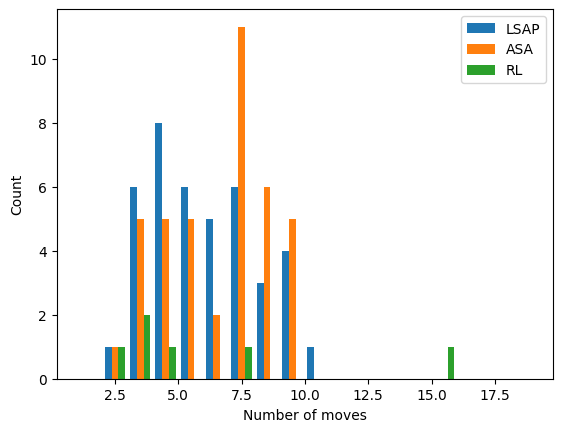

In [127]:
plt.hist(num_moves, bins=range(1, 20), histtype="bar")
plt.legend(names)
plt.xlabel("Number of moves")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

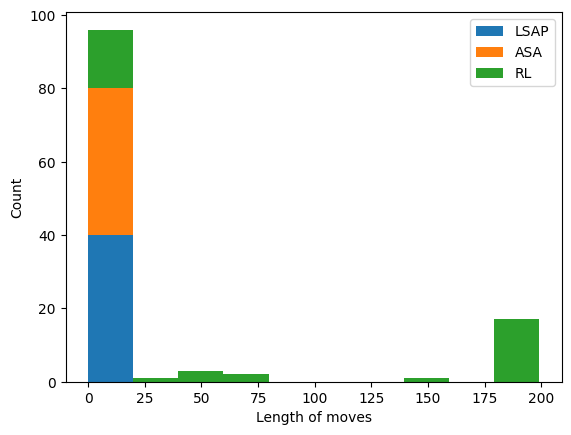

In [128]:
plt.hist(move_length, histtype="barstacked")
plt.legend(names)
plt.xlabel("Length of moves")
plt.ylabel("Count")

In [79]:
num_moves

[[9,
  4,
  6,
  8,
  3,
  3,
  5,
  3,
  9,
  7,
  7,
  9,
  9,
  6,
  6,
  3,
  7,
  8,
  8,
  10,
  3,
  5,
  4,
  5,
  2,
  4,
  5,
  7,
  4,
  6,
  4,
  5,
  3,
  5,
  4,
  7,
  6,
  4,
  4,
  7],
 [9,
  4,
  6,
  8,
  3,
  4,
  8,
  3,
  8,
  7,
  9,
  9,
  9,
  7,
  7,
  3,
  7,
  8,
  8,
  9,
  3,
  7,
  5,
  5,
  2,
  4,
  7,
  7,
  4,
  6,
  5,
  7,
  3,
  7,
  4,
  5,
  8,
  5,
  7,
  7],
 [0,
  0,
  99,
  0,
  99,
  21,
  99,
  15,
  92,
  0,
  0,
  98,
  0,
  99,
  0,
  95,
  97,
  0,
  61,
  0,
  84,
  7,
  95,
  99,
  66,
  2,
  95,
  0,
  4,
  100,
  71,
  0,
  49,
  99,
  0,
  3,
  0,
  99,
  3,
  99]]

# Start visualization

In [17]:
%matplotlib notebook

In [18]:
def obs_to_plots(obs, atoms_plt, mt_plt):
    atom_grid, tar_grid, mt_grid = obs[0]
    
    dots = [[], []]
    mt_pos = (0, 0)
    for i in range(n):
        for j in range(n):
            if mt_grid[i, j] != 0:
                mt_pos = (i, j, mt_grid[i, j])
            if atom_grid[i, j] == 1:
                dots[0].append(i)
                dots[1].append(j)
    print(obs)
    atoms_plt.set_data(dots)
    mt_plt.set_data(mt_pos[0], mt_pos[1])
    mt_plt.set_marker('x' if mt_pos[2] == 1 else 'o')
    
    return atoms_plt, mt_plt

In [ ]:
fig, ax = plt.subplots()

n = args.ArraySize
ax.set_xlim(-1, n)
ax.set_ylim(-1, n)

obs = envs.reset()
atom_grid, tar_grid, mt_grid = obs[0]
dots = [[], []]
for i in range(n):
    for j in range(n):
        if tar_grid[i, j] == 1:
            dots[0].append(i)
            dots[1].append(j)

targets, = ax.plot(dots[0], dots[1], 'gs', markersize=12, markerfacecolor=(1, 1, 0, 0.5))
atoms, = ax.plot([], [], 'bo')
mt, = ax.plot(0, 0, 'ro', markersize=10)

# obs_to_plots(obs, atoms, mt)

next_obs = torch.Tensor(obs)
done = False
def animate(frame_num):    
    if done[0]:
        ax.set_title("boobler")
        return None
    
    ax.set_title("boobler")
    with torch.no_grad():
        action, logprob, _, _ = agent.get_action_and_value(next_obs)
        
    next_obs, reward, done, info = envs.step(action.cpu().numpy())
    print(next_obs)
    atoms, mt = obs_to_plots(next_obs, atoms, mt)
    
    next_obs = torch.Tensor(next_obs)
    done = [done,]
    return (atoms, mt)

anim = FuncAnimation(fig, animate, frames=5, interval=1000, blit=True)

plt.show()

## Masking testing

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [120]:
obs1 = torch.tensor([[[0,1,1,1,1],[0,1,1,1,0],[1,0,1,0,1],[0,1,1,0,0],[1,0,1,1,0]],[[0,0,0,0,0],[0,1,1,1,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,1],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])
obs2 = torch.tensor([[[0,1,1,1,1],[0,1,1,1,1],[1,0,1,0,1],[0,1,1,0,0],[1,0,1,1,0]],[[0,0,0,0,0],[0,1,1,1,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[0,0,0,0,2],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])

batch = torch.tensor((obs1.numpy(), obs2.numpy()))

In [121]:
kernel = torch.tensor([[[[0, 1000, 0],[10, 10000, 1],[0, 100, 0]],  [[0, 0, 0],[0, 0, 0],[0, 0, 0]],  [[0, 0, 0],[0, 100000, 0],[0, 0, 0]]]])


In [122]:
has_atoms = torch.amax(batch, (1, 2, 3))

padded = F.pad(batch, (1,)*4, value=2)
detect = F.conv2d(padded, kernel)
inter_masks = torch.amax(detect, (1, 2, 3))

inter_masks = inter_masks + inter_masks * (has_atoms == 2)
masks_ = torch.column_stack((
    inter_masks % 10000 < 2000,
    inter_masks % 1000 < 200,
    inter_masks % 100 < 20,
    inter_masks % 10 < 2,
    torch.logical_and(has_atoms == 1, inter_masks % 100000 >= 10000),
    has_atoms == 2
))

In [123]:
masks_

tensor([[ True,  True,  True, False, False, False],
        [False, False, False, False, False,  True]])

In [124]:
obs1

tensor([[[0, 1, 1, 1, 1],
         [0, 1, 1, 1, 0],
         [1, 0, 1, 0, 1],
         [0, 1, 1, 0, 0],
         [1, 0, 1, 1, 0]],

        [[0, 0, 0, 0, 0],
         [0, 1, 1, 1, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]])

In [125]:
inter_masks

tensor([101112, 422224])

In [119]:
inter_masks

tensor([111112, 422224])

In [100]:
has_atoms

tensor([1, 2])

In [60]:
torch.amax(obs, 2)

tensor([[1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [77]:
batch = torch.tensor((obs.numpy(), obs.numpy()*2))
has_atom = torch.amax(batch, (1, 2, 3))
has_atom == 1, has_atom == 2

(tensor([ True, False]), tensor([False,  True]))

In [111]:
batch.shape

torch.Size([2, 3, 5, 5])